In [284]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime
import re
import numpy as np

# from sklearn.surprise import Dataset, Reader
# from surprise.model_selection import train_test_split
# from surprise import SVD

In [285]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

In [286]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Data Cleaning

In [287]:
# Checking and removing NaNs

movies_nan = movies.isna().sum()
ratings_nan = ratings.isna().sum()
tags_nan = tags.isna().sum()
links_nan = links.isna().sum()
print("NaN counts in movies:\n", movies_nan)
print("\nNaN counts in ratings:\n", ratings_nan)
print("\nNaN counts in tags:\n", tags_nan)
print("\nNaN counts in links:\n", links_nan)

# TMDB ID the only column with NaNs
links['tmdbId'].fillna('Unknown', inplace=True)




NaN counts in movies:
 movieId    0
title      0
genres     0
dtype: int64

NaN counts in ratings:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

NaN counts in tags:
 userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

NaN counts in links:
 movieId    0
imdbId     0
tmdbId     8
dtype: int64


In [288]:
# Removing duplicates
ratings.drop_duplicates(subset=['userId', 'movieId'], inplace=True)
tags.drop_duplicates(subset=['userId', 'movieId', 'tag'], inplace=True)

# Data type conversion
movies['movieId'] = movies['movieId'].astype(int)
ratings['userId'] = ratings['userId'].astype(int)
ratings['movieId'] = ratings['movieId'].astype(int)

# Standardizing text
movies['title'] = movies['title'].str.lower()
tags['tag'] = tags['tag'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s]', '', x).lower())

movies['genres'] = movies['genres'].str.split('|')

# Assuming the 'timestamp' column is in your 'ratings' DataFrame
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')




## Data Merging

In [289]:
movie_ratings = pd.merge(movies, ratings, on='movieId')
movie_ratings_tags = pd.merge(movie_ratings, tags, on=['movieId', 'userId'], how='left')
final_dataset = pd.merge(movie_ratings_tags, links, on='movieId', how='left')
final_dataset.head()

,movieId,title,genres,userId,rating,timestamp_x,tag,timestamp_y,imdbId,tmdbId
0,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,4.0,2000-07-30 18:45:03,NaN,NaT,114709,862.0
1,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,4.0,1996-11-08 06:36:02,NaN,NaT,114709,862.0
2,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",7,4.5,2005-01-25 06:52:26,NaN,NaT,114709,862.0
3,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",15,2.5,2017-11-13 12:59:30,NaN,NaT,114709,862.0
4,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",17,4.5,2011-05-18 05:28:03,NaN,NaT,114709,862.0


In [290]:
final_dataset_nan = final_dataset.isna().sum()
print("NaN counts in movies:\n", final_dataset_nan)
# Counting non-NaN values in the 'tag' column
non_nan_count_tag = final_dataset['tag'].notna().sum()

# Displaying the count
print("Number of non-NaN values in 'tag':", non_nan_count_tag)
# Counting non-NaN values in the 'tag' column
non_nan_count_timestamp_y = final_dataset['timestamp_y'].notna().sum()

# Displaying the count
print("Number of non-NaN values in 'timestamp_y':", non_nan_count_timestamp_y)

# Fill NaN values in 'tag' with 'No Tag'
final_dataset['tag'].fillna('No Tag', inplace=True)

# Drop 'timestamp_y' if not needed
final_dataset.drop(columns=['timestamp_y'], inplace=True)

final_dataset = final_dataset.rename(columns={'timestamp_x': 'timestamp'})


final_dataset.head()

NaN counts in movies:
 movieId            0
title              0
genres             0
userId             0
rating             0
timestamp_x        0
tag            99201
timestamp_y    99201
imdbId             0
tmdbId             0
dtype: int64
Number of non-NaN values in 'tag': 3476
Number of non-NaN values in 'timestamp_y': 3476


,movieId,title,genres,userId,rating,timestamp,tag,imdbId,tmdbId
0,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,4.0,2000-07-30 18:45:03,No Tag,114709,862.0
1,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,4.0,1996-11-08 06:36:02,No Tag,114709,862.0
2,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",7,4.5,2005-01-25 06:52:26,No Tag,114709,862.0
3,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",15,2.5,2017-11-13 12:59:30,No Tag,114709,862.0
4,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",17,4.5,2011-05-18 05:28:03,No Tag,114709,862.0


## Feature Engineering- Timestamps to reflect trends

In [291]:
from datetime import datetime
import numpy as np

# Adjust the decay factor
decay_factor = 0.99

# Ensure correct conversion of timestamp to datetime
final_dataset['timestamp'] = pd.to_datetime(final_dataset['timestamp'])

# Calculate the age of each rating
current_date = pd.to_datetime('now')
final_dataset['rating_age_days'] = (current_date - final_dataset['timestamp']).dt.days

# Apply the decay function
final_dataset['rating_weight'] = decay_factor ** final_dataset['rating_age_days']

# Calculate the weighted rating score (without dividing by frequency)
weighted_rating_score = final_dataset.groupby('movieId').apply(lambda x: np.mean(x['rating_weight'])).reset_index(name='weighted_rating_score')

# Normalize the scores (optional, can use min-max scaling or z-score standardization)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
weighted_rating_score['normalized_score'] = scaler.fit_transform(weighted_rating_score[['weighted_rating_score']])

# Merge with the main dataset if needed
final_dataset = final_dataset.merge(weighted_rating_score, on='movieId')

# Now, you can use 'normalized_score' as your trending score


C:\Users\betht\AppData\Local\Temp\ipykernel_11408\898363556.py:11: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  current_date = pd.to_datetime('now')


In [292]:
import matplotlib.pyplot as plt

# Assuming 'trending_score' is the column containing normalized scores in your DataFrame
trending_scores = final_dataset['normalized_score']

# Plotting a histogram
plt.hist(normalized_score, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Normalized Trending Scores')
plt.xlabel('Normalized Trending Score')
plt.ylabel('Frequency')
plt.show()
highest_normalized_score = final_dataset['normalized_score'].describe()
print(highest_normalized_score)


NameError: name 'normalized_scores' is not defined

In [ ]:
# Determining the recency of each rating
current_date = pd.to_datetime('now')
final_dataset['rating_age_days'] = (current_date - final_dataset['timestamp']).dt.days

# Calculating the frequency of each movie. Counting the number of ratings for each movie. Higher number of recent ratings could indicate a trend.
rating_counts = final_dataset.groupby('movieId').size()
final_dataset['rating_frequency'] = final_dataset['movieId'].map(rating_counts)

C:\Users\betht\AppData\Local\Temp\ipykernel_11408\1748269917.py:2: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  current_date = pd.to_datetime('now')


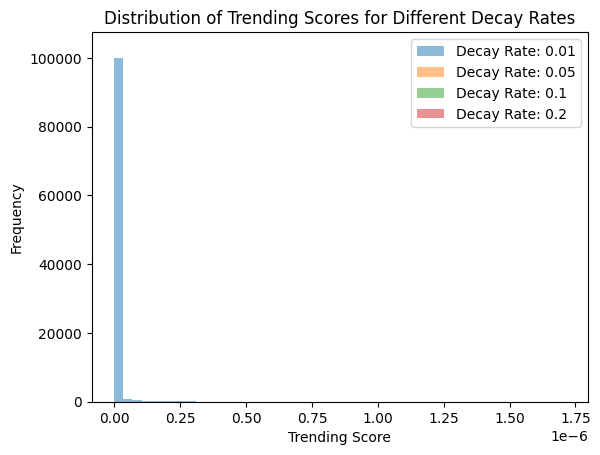

In [ ]:
# Experiment with different decay rates
decay_rates = [0.01, 0.05, 0.1, 0.2]  # Add more values if needed

for decay_rate in decay_rates:
    final_dataset['recency_weight'] = np.exp(-decay_rate * final_dataset['rating_age_days'])
    final_dataset['trending_score'] = final_dataset['rating_frequency'] * final_dataset['recency_weight']
    
    # Visualize the distribution of trending scores for each decay rate
    plt.hist(final_dataset['trending_score'], bins=50, alpha=0.5, label=f'Decay Rate: {decay_rate}')

plt.title('Distribution of Trending Scores for Different Decay Rates')
plt.xlabel('Trending Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
# Determining the recency of each rating
current_date = pd.to_datetime('now')
final_dataset['rating_age_days'] = (current_date - final_dataset['timestamp']).dt.days

# Calculating the frequency of each movie. Counting the number of ratings for each movie. Higher number of recent ratings could indicate a trend.
rating_counts = final_dataset.groupby('movieId').size()
final_dataset['rating_frequency'] = final_dataset['movieId'].map(rating_counts)

# Using only the exponential decay function for recency weight
decay_rate = 0.001  # Adjust as needed
final_dataset['recency_weight'] = np.exp(-decay_rate * final_dataset['rating_age_days'])

# Proceed with the rest of the calculations
final_dataset['trending_score'] = final_dataset['rating_frequency'] * final_dataset['recency_weight']

# Normalize the trending scores using standardization (z-score)
trending_mean = final_dataset['trending_score'].mean()
trending_std = final_dataset['trending_score'].std()

# Check if the standard deviation is not zero before normalization
if trending_std != 0:
    final_dataset['trending_score'] = (final_dataset['trending_score'] - trending_mean) / trending_std
else:
    # If standard deviation is zero, handle it appropriately (e.g., set all scores to zero)
    final_dataset['trending_score'] = 0


C:\Users\betht\AppData\Local\Temp\ipykernel_11408\705628905.py:2: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  current_date = pd.to_datetime('now')


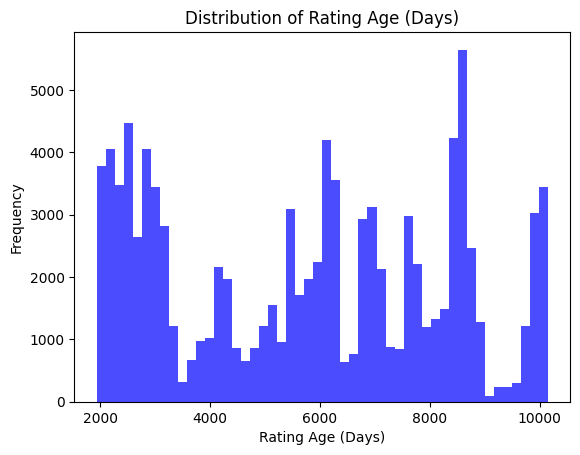

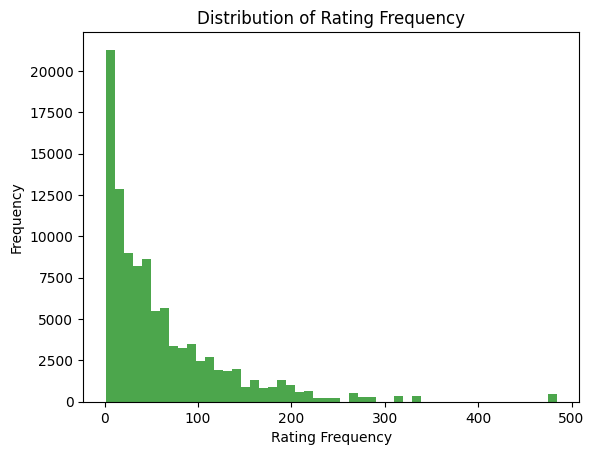

In [ ]:
# Check distribution of rating_age_days
plt.hist(final_dataset['rating_age_days'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Rating Age (Days)')
plt.xlabel('Rating Age (Days)')
plt.ylabel('Frequency')
plt.show()

# Check distribution of rating_frequency
plt.hist(final_dataset['rating_frequency'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of Rating Frequency')
plt.xlabel('Rating Frequency')
plt.ylabel('Frequency')
plt.show()


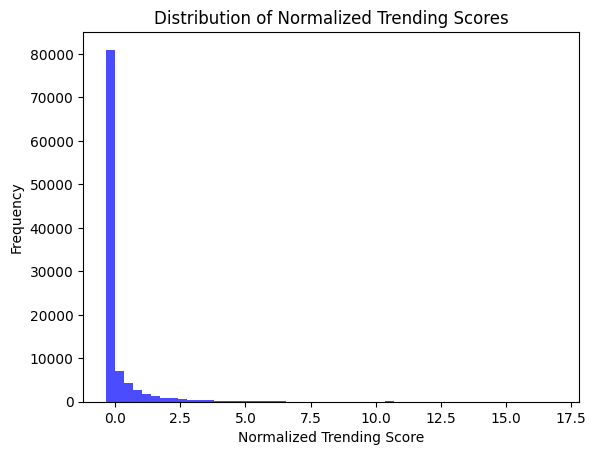

count    1.026770e+05
mean    -3.294003e-17
std      1.000000e+00
min     -3.696250e-01
25%     -3.669894e-01
50%     -3.457665e-01
75%     -1.382156e-01
max      1.695651e+01
Name: trending_score, dtype: float64


In [ ]:
import matplotlib.pyplot as plt

# Assuming 'trending_score' is the column containing normalized scores in your DataFrame
trending_scores = final_dataset['trending_score']

# Plotting a histogram
plt.hist(trending_scores, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Normalized Trending Scores')
plt.xlabel('Normalized Trending Score')
plt.ylabel('Frequency')
plt.show()
highest_trending_score = final_dataset['trending_score'].describe()
print(highest_trending_score)


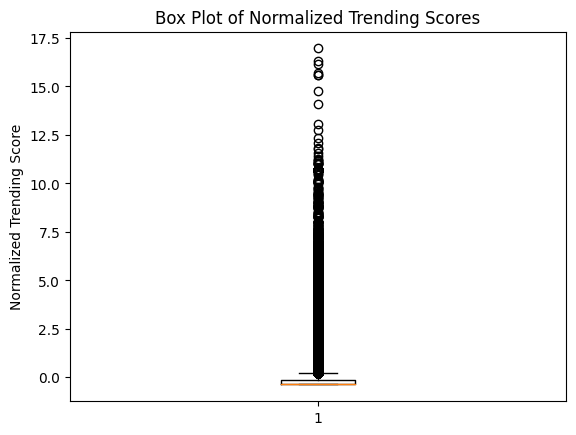

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'trending_score' is the column containing normalized scores in your DataFrame
trending_scores = final_dataset['trending_score']

# Plotting a box plot
plt.boxplot(trending_scores)
plt.title('Box Plot of Normalized Trending Scores')
plt.ylabel('Normalized Trending Score')
plt.show()


In [ ]:
# Determining the recency of each rating
current_date = pd.to_datetime('now')
final_dataset['rating_age_days'] = (current_date - final_dataset['timestamp']).dt.days
# Calculating the frequency of each movie. Counting the number of ratings for each movie. Higher number of recent ratings could indicate a trend.
rating_counts = final_dataset.groupby('movieId').size()
final_dataset['rating_frequency'] = final_dataset['movieId'].map(rating_counts)
# Using only the exponential decay function for recency weight
decay_rate = 0.05  # Adjust as needed
final_dataset['recency_weight'] = np.exp(-decay_rate * final_dataset['rating_age_days'])

# Proceed with the rest of the calculations
final_dataset['trending_score'] = final_dataset['rating_frequency'] * final_dataset['recency_weight']

# Normalize the trending scores using a different method if needed
# Example: Standardization
trending_mean = final_dataset['trending_score'].mean()
trending_std = final_dataset['trending_score'].std()
final_dataset['trending_score'] = (final_dataset['trending_score'] - trending_mean) / trending_std


C:\Users\betht\AppData\Local\Temp\ipykernel_11408\2196554546.py:2: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  current_date = pd.to_datetime('now')


In [ ]:
# # Using only the exponential decay function for recency weight
# decay_rate = 0.001  # Adjust as needed
# final_dataset['recency_weight'] = np.exp(-decay_rate * final_dataset['rating_age_days'])

# # Proceed with the rest of the calculations
# final_dataset['trending_score'] = final_dataset['rating_frequency'] * final_dataset['recency_weight']

# # Normalize the trending scores using a different method if needed
# # Example: Standardization
# trending_mean = final_dataset['trending_score'].mean()
# trending_std = final_dataset['trending_score'].std()
# final_dataset['trending_score'] = (final_dataset['trending_score'] - trending_mean) / trending_std


In [ ]:
# # Determining the recency of each rating
# current_date = pd.to_datetime('now')
# final_dataset['rating_age_days'] = (current_date - final_dataset['timestamp']).dt.days

# # Calculating the frequency of each movie. Counting the number of ratings for each movie. Higher number of recent ratings could indicate a trend.
# rating_counts = final_dataset.groupby('movieId').size()
# final_dataset['rating_frequency'] = final_dataset['movieId'].map(rating_counts)

# # Weighted score combining recency and frequency
# # Adjusting recency weight with a decay function
# decay_rate = 0.05
# final_dataset['recency_weight'] = np.exp(-decay_rate * final_dataset['rating_age_days'])
# # Inverse the age to give more weight to recent ratings
# final_dataset['recency_weight'] = 1 / (1 + final_dataset['rating_age_days'])

# # Calculate the trending score by multiplying the frequency by the recency weight
# final_dataset['trending_score'] = final_dataset['rating_frequency'] * final_dataset['recency_weight']
# # Normalize the trending scores
# final_dataset['trending_score'] = (
#     final_dataset['trending_score'] - final_dataset['trending_score'].min()) / (
#     final_dataset['trending_score'].max() - final_dataset['trending_score'].min())
# # # Normalize to a 0-1 scale
# # final_dataset['trending_score'] = (
# #     final_dataset['trending_score'] - final_dataset['trending_score'].min()) / (
# #     final_dataset['trending_score'].max() - final_dataset['trending_score'].min())

# # Take the mean trending score for each movie
# #movie_trending_scores = final_dataset.groupby('movieId')['trending_score'].mean().reset_index()

# final_dataset.head()


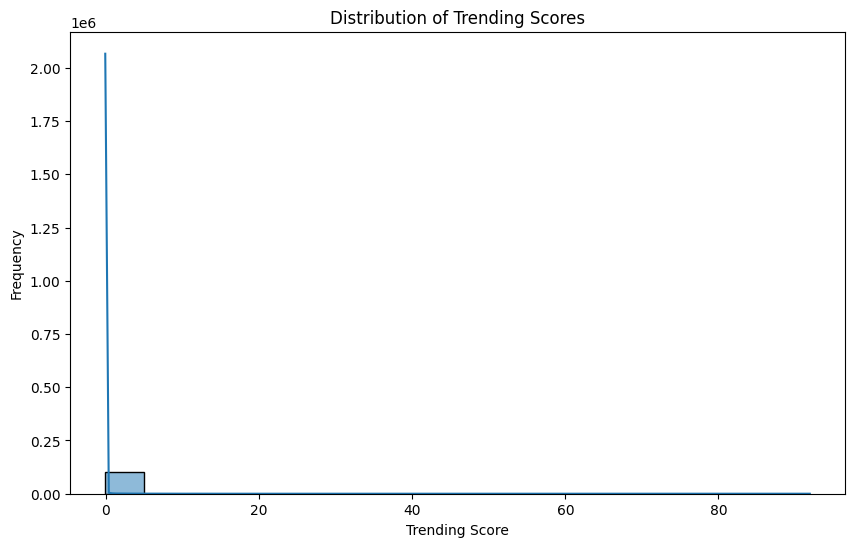

count    1.026770e+05
mean     2.048372e-17
std      1.000000e+00
min     -7.265266e-02
25%     -7.265266e-02
50%     -7.265266e-02
75%     -7.265266e-02
max      9.192301e+01
Name: trending_score, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of 'trending score'
plt.figure(figsize=(10, 6))
sns.histplot(final_dataset['trending_score'], kde=True)
plt.title('Distribution of Trending Scores')
plt.xlabel('Trending Score')
plt.ylabel('Frequency')
plt.show()
highest_trending_score = final_dataset['trending_score'].describe()
print(highest_trending_score)


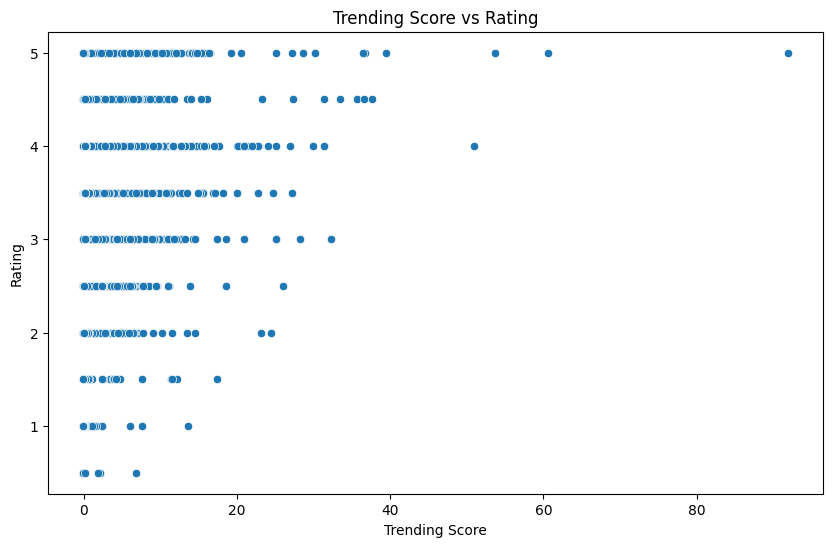

Correlation between Trending Score and Rating: 0.024083559452765704


In [ ]:
# Scatter plot of 'trending score' vs 'ratings'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trending_score', y='rating', data=final_dataset)
plt.title('Trending Score vs Rating')
plt.xlabel('Trending Score')
plt.ylabel('Rating')
plt.show()

# Calculating the correlation
correlation = final_dataset['trending_score'].corr(final_dataset['rating'])
print("Correlation between Trending Score and Rating:", correlation)


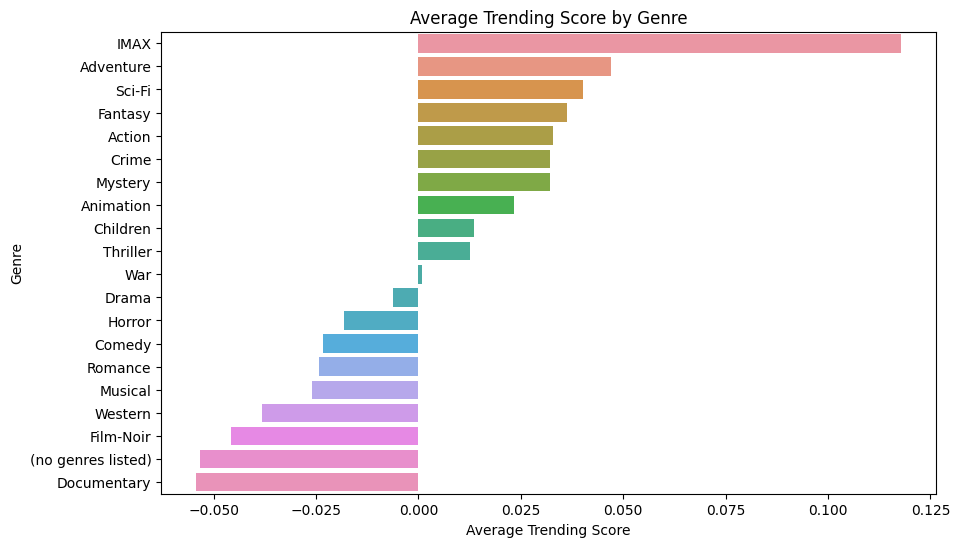

In [ ]:
# Assuming 'genres' is a list of genres for each movie
# If 'genres' is a string, you need to convert it into a list first
from itertools import chain

# Create a DataFrame where each genre is associated with a movie
genre_df = final_dataset['genres'].apply(pd.Series).stack().reset_index(level=1, drop=True).to_frame('genre')

# Merge this with the original DataFrame
genre_trending = final_dataset.merge(genre_df, left_index=True, right_index=True)

# Group by genre and calculate average trending score
genre_trending_score = genre_trending.groupby('genre')['trending_score'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_trending_score.values, y=genre_trending_score.index)
plt.title('Average Trending Score by Genre')
plt.xlabel('Average Trending Score')
plt.ylabel('Genre')
plt.show()
